# HPGe Simulation

Importing libraries and initialising global constants

In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.signal import peak_widths
import os
import openmc_tools

In [2]:
#taken from europium gamma decay spectrum, all decay channels with an intensity >0.01%
europium_energy_peaks_ev = np.array([121781.7, 125690, 148010, 212568, 244697.4, 251633, 271131, 275449, 285980, 295938.7, 315174, 324830, 329425, 340400,
                           344278.5, 351660, 367789.1, 411116.5, 416048, 440860, 443965, 482310, 488679.2, 493508, 503474, 511000, 520227, 523130,
                           526881, 534245, 556560, 562930, 563990, 566442, 586265, 656489, 664780, 671155, 674675, 674677, 678623, 686610, 688670,
                           712843, 719349, 727990, 764900, 768944, 778904.5, 794810, 810451, 839360, 841574, 867380, 896580, 901181, 906010, 919337,
                           926317, 930580, 958630, 963390, 964079, 974090, 990190, 1005272, 1084000, 1085337, 1089737, 1109174, 1112076, 1170930,
                           1206110, 1212948, 1249938, 1261343, 1292778, 1299142, 1348100, 1363770, 1408013, 1457643, 1528103])

europium_decay_intensities = np.array([28.41, 0.019, 0.035, 0.0196, 7.55, 0.0671, 0.078, 0.0323, 0.01, 0.442, 0.0496, 0.0738, 0.129, 0.031, 26.59,
                                        0.014, 0.862, 2.238, 0.109, 0.0133, 0.32, 2.8, 0.0279, 0.4139, 0.0278, 0.1533, 0.054, 0.0536, 0.0113, 0.0129, 
                                        0.0368, 0.0177, 0.038, 0.457, 0.131, 0.462,  0.1437, 0.01, 0.0194, 0.17, 0.0171, 0.47, 0.02, 0.841, 0.0961,
                                        0.268, 0.0106, 0.19, 0.088, 12.97, 0.0263, 0.317, 0.016, 4.243, 0.0669, 0.084, 0.016, 0.429, 0.273, 0.0729,
                                        0.021, 0.1341, 14.5, 0.0138, 0.0315, 0.665, 0.244, 10.13, 1.73, 0.186, 13.41, 0.0365, 0.0135, 1.416, 0.186,
                                        0.0336, 0.104, 1.633, 0.0175, 0.0256, 20.85, 0.498, 0.281])


cobalt_energy_peaks_ev = np.array([347140, 826100, 1173222.8, 1332492, 2158570, 2505692])
cobalt_decay_intensities = np.array([0.0075, 0.0076, 99.85, 99.9826, 0.0012, 0.000002])

americium_energy_peaks_ev = np.array([26344.6, 32183, 33196.3, 43420, 55560, 59540.9, 98970, 102980])
americium_decay_intensities = np.array([2.31, 0.0174, 0.1215, 0.0669, 0.0181, 35.92, 0.0203, 0.0195])

europium_decay_probabilities = openmc_tools.find_decay_probabilities(europium_decay_intensities)
cobalt_decay_probabilities = openmc_tools.find_decay_probabilities(cobalt_decay_intensities)
americium_decay_probabilities = openmc_tools.find_decay_probabilities(americium_decay_intensities)

In [3]:
time_since_calibration = 999 * 86400 #seconds, accurate to nearest day

cobalt_initial_activity = 43000 #kBq
americium_initial_activity = 41400 #kBq

cobalt_half_life = 5.271 * 365 * 24 * 60 * 60
americium_half_life = 432.6 * 365 * 24 * 60 * 60 #half life taken from nndc

cobalt_activity = openmc_tools.find_current_activity(cobalt_initial_activity, time_since_calibration, cobalt_half_life)
americium_activity = openmc_tools.find_current_activity(americium_initial_activity, time_since_calibration, americium_half_life)

## Defining the materials

In [4]:
#materials
aluminium_mat = openmc.Material()
aluminium_mat.add_element('Al', 1, percent_type = 'ao')
aluminium_mat.set_density('g/cm3', 2.6989)

beryllium_mat = openmc.Material()
beryllium_mat.add_element('Be', 1, percent_type = 'ao')
beryllium_mat.set_density('g/cm3', 1.848)

copper_mat = openmc.Material()
copper_mat.add_element('Cu', 1, percent_type = 'ao')
copper_mat.set_density('g/cm3', 8.96)

germanium_mat = openmc.Material()
germanium_mat.add_element('Ge', 1, percent_type = 'ao')
germanium_mat.set_density('g/cm3', 5.323)

lead_mat = openmc.Material()
lead_mat.add_element('Pb', 1, percent_type = 'ao')
lead_mat.set_density('g/cm3', 11.35)

mylar_mat = openmc.Material()
mylar_mat.add_element('C', 10, percent_type = 'ao')
mylar_mat.add_element('H', 8, percent_type = 'ao')
mylar_mat.add_element('O', 4, percent_type = 'ao')
mylar_mat.set_density('g/cm3', 1.38)

vacuum_mat = openmc.Material()#setting a vacuum material as air with a near-zero density
vacuum_mat.add_element('C', 0.00015, percent_type = 'ao')
vacuum_mat.add_element('N', 0.784429, percent_type = 'ao')
vacuum_mat.add_element('O', 0.210750, percent_type = 'ao')
vacuum_mat.add_element('Ar', 0.004671, percent_type = 'ao')
vacuum_mat.set_density('g/cm3', 0.001)


materials = openmc.Materials([aluminium_mat, beryllium_mat, copper_mat, germanium_mat, lead_mat, mylar_mat, vacuum_mat])
materials.export_to_xml()

## Defining the geometries

In [5]:
#surfaces

lead_shield_out = openmc.model.RightCircularCylinder([0, 0, -28], 61, 28.5, axis = 'z', boundary_type = 'vacuum')
lead_shield_in = openmc.model.RightCircularCylinder([0, 0, -23], 46, 12.5, axis = 'z', boundary_type = 'vacuum')

outer_cylinder_out = openmc.model.RightCircularCylinder([0, 0, -23], 23, 5, axis = 'z')
outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -23], 22.9, 4.9, axis = 'z')

aluminium_case_out = openmc.model.RightCircularCylinder([0, 0, -11.006], 10.5, 4.5, axis = 'z')
aluminium_case_in = openmc.model.RightCircularCylinder([0, 0, -10.706], 10.2, 4.42, axis = 'z')

aluminium_layer = openmc.model.RightCircularCylinder([0, 0, -0.506], 0.003, 4.5, axis = 'z')
mylar_layer = openmc.model.RightCircularCylinder([0, 0, -0.503], 0.003, 4.5, axis = 'z')

germanium_crystal = openmc.model.RightCircularCylinder([0, 0, -5.536], 5.03, 3.5, axis = 'z')
germanium_crystal.id = 1

#germanium_crystal_top = openmc.ZPlane(z0=-5.543 + 7.07, boundary_type='transmission')

interior_hole_cylinder = openmc.model.RightCircularCylinder((0, 0, -23), 20.644, 0.44, axis = 'z')
interior_hole_sphere = openmc.Sphere(0, 0, -2.356, 0.44)

Rounded Hole Region: ((-28 29 -30) | -31)
Lead Shield Region: (-1 2 -3 (4 | -5 | 6))
Outer Cylinder Region: (-7 8 -9 (10 | -11 | 12) ~((-28 29 -30) | -31))
Aluminium Case Region: (-13 14 -15 (16 | -17 | 18) ~((-28 29 -30) | -31))
Aluminium Layer Region: (-19 20 -21)
Mylar Layer Region: (-22 23 -24)
Germanium Crystal Region: (-25 26 -27 ~((-28 29 -30) | -31))
Vacuum Region: (-4 5 -6 ~(-7 8 -9 (10 | -11 | 12) ~((-28 29 -30) | -31)) ~(-13 14 -15 (16 | -17 | 18) ~((-28 29 -30) | -31)) ~(-19 20 -21) ~(-22 23 -24) ~(-25 26 -27 ~((-28 29 -30) | -31)))


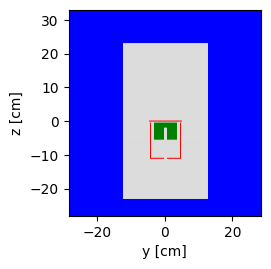

In [6]:
colour_assignment = {aluminium_mat: 'red', beryllium_mat: 'yellow', copper_mat: 'cyan', lead_mat: 'blue', germanium_mat: 'green', mylar_mat: 'purple',
                    vacuum_mat: 'gainsboro'}

rounded_hole_region = -interior_hole_cylinder | -interior_hole_sphere
print(f"Rounded Hole Region: {rounded_hole_region}")

lead_shield_region = -lead_shield_out & +lead_shield_in
print(f"Lead Shield Region: {lead_shield_region}")
lead_shield_cell = openmc.Cell(region = lead_shield_region)
lead_shield_cell.fill = lead_mat

outer_cylinder_region = -outer_cylinder_out & +outer_cylinder_in & ~rounded_hole_region
print(f"Outer Cylinder Region: {outer_cylinder_region}")
outer_cylinder_cell = openmc.Cell(region = outer_cylinder_region)
outer_cylinder_cell.fill = aluminium_mat

aluminium_case_region = -aluminium_case_out & +aluminium_case_in & ~rounded_hole_region
print(f"Aluminium Case Region: {aluminium_case_region}")
aluminium_case_cell = openmc.Cell(region = aluminium_case_region)
aluminium_case_cell.fill = aluminium_mat

aluminium_layer_region = -aluminium_layer
print(f"Aluminium Layer Region: {aluminium_layer_region}")
aluminium_layer_cell = openmc.Cell(region = aluminium_layer_region)
aluminium_layer_cell.fill = aluminium_mat

mylar_layer_region = -mylar_layer
print(f"Mylar Layer Region: {mylar_layer_region}")
mylar_layer_cell = openmc.Cell(region = mylar_layer_region)
mylar_layer_cell.fill = mylar_mat

germanium_crystal_region = -germanium_crystal & ~rounded_hole_region
print(f"Germanium Crystal Region: {germanium_crystal_region}")
germanium_crystal_cell = openmc.Cell(region = germanium_crystal_region)
germanium_crystal_cell.fill = germanium_mat

vacuum_region = -lead_shield_in & ~outer_cylinder_region & ~aluminium_case_region & ~aluminium_layer_region & ~mylar_layer_region & ~germanium_crystal_region
print(f"Vacuum Region: {vacuum_region}")
vacuum_cell = openmc.Cell(region=vacuum_region)
vacuum_cell.fill = vacuum_mat

geometry = openmc.Geometry([lead_shield_cell, outer_cylinder_cell, aluminium_case_cell, germanium_crystal_cell, aluminium_layer_cell, 
                            mylar_layer_cell, vacuum_cell])

plot = geometry.plot(basis = 'yz', color_by = 'material', colors = colour_assignment)

geometry.export_to_xml()


## Creating settings

In [7]:
num_particles = 100000
num_batches = 100
source_loc = (0, 0, 0.5)
    
europium_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, europium_energy_peaks_ev, europium_decay_probabilities)
cobalt_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, cobalt_energy_peaks_ev, cobalt_decay_probabilities)
americium_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, americium_energy_peaks_ev, americium_decay_probabilities)

energy_bins = np.linspace(americium_energy_peaks_ev[0]-10000, cobalt_energy_peaks_ev[-1]+10000, num = num_particles)
tallies = openmc_tools.create_hpge_spectrum_tally(germanium_crystal_cell, energy_bins)

## Running initial HPGe spectra simulation

In [8]:
%%time

europium_results = openmc_tools.openmc_sim(geometry, materials, europium_settings, tallies)
europium_spectrum = europium_results["pulse_height"]

cobalt_results = openmc_tools.openmc_sim(geometry, materials, cobalt_settings, tallies)
cobalt_spectrum = cobalt_results["pulse_height"]
scaled_cobalt_spectrum = openmc_tools.scale_pulse_height_spectra(cobalt_spectrum, cobalt_activity, cobalt_initial_activity)

americium_results = openmc_tools.openmc_sim(geometry, materials, americium_settings, tallies)
americium_spectrum = americium_results["pulse_height"]
scaled_americium_spectrum = openmc_tools.scale_pulse_height_spectra(americium_spectrum, americium_activity, americium_initial_activity)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

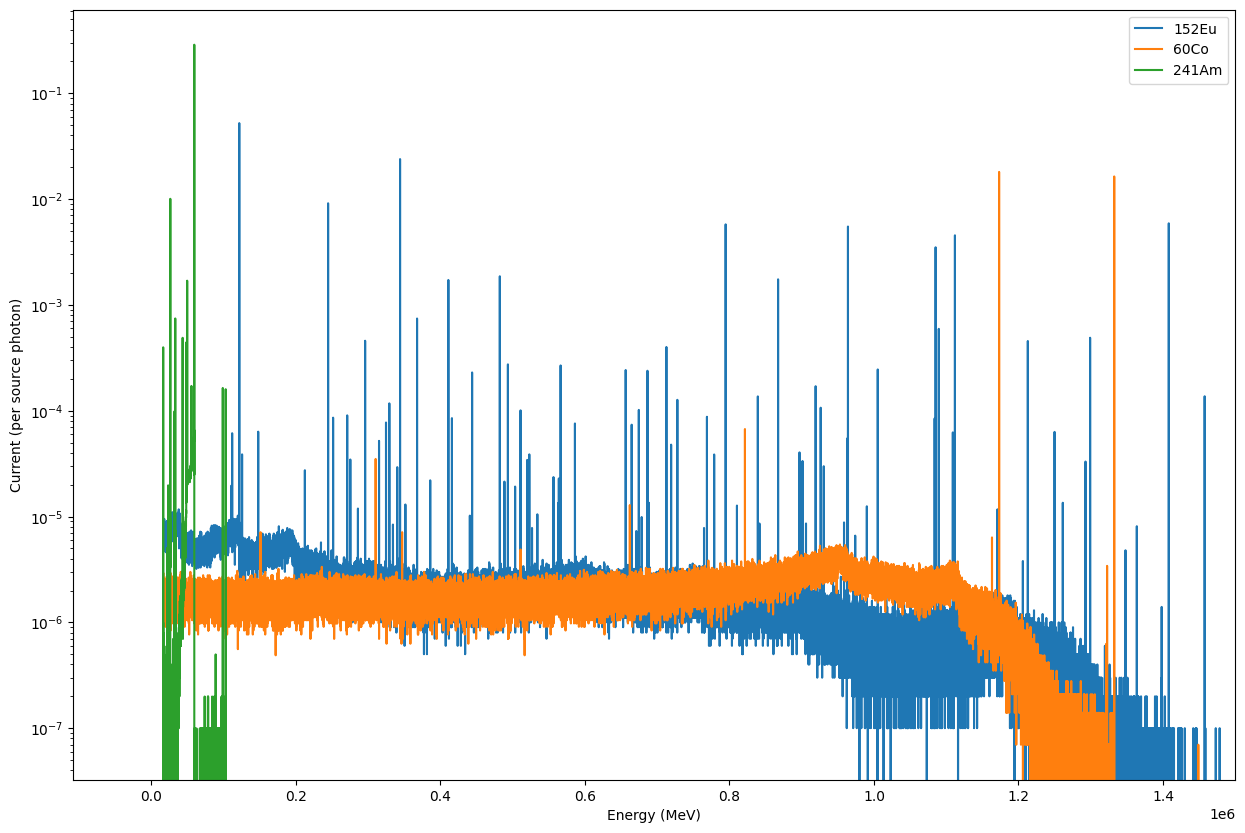

In [9]:
plt.figure(figsize = [15, 10])
results_array = [europium_spectrum, scaled_cobalt_spectrum, scaled_americium_spectrum]
labels = ["152Eu", "60Co", "241Am"]

for i in range(len(results_array)):
    plt.plot(energy_bins[:-1], results_array[i], label = labels[i])
    
plt.yscale('log')
plt.xlim(right = 1.5E6)
plt.xlabel('Energy (MeV)')
plt.ylabel('Current (per source photon)')
plt.legend()
plt.show()

## Removing the background spectrum

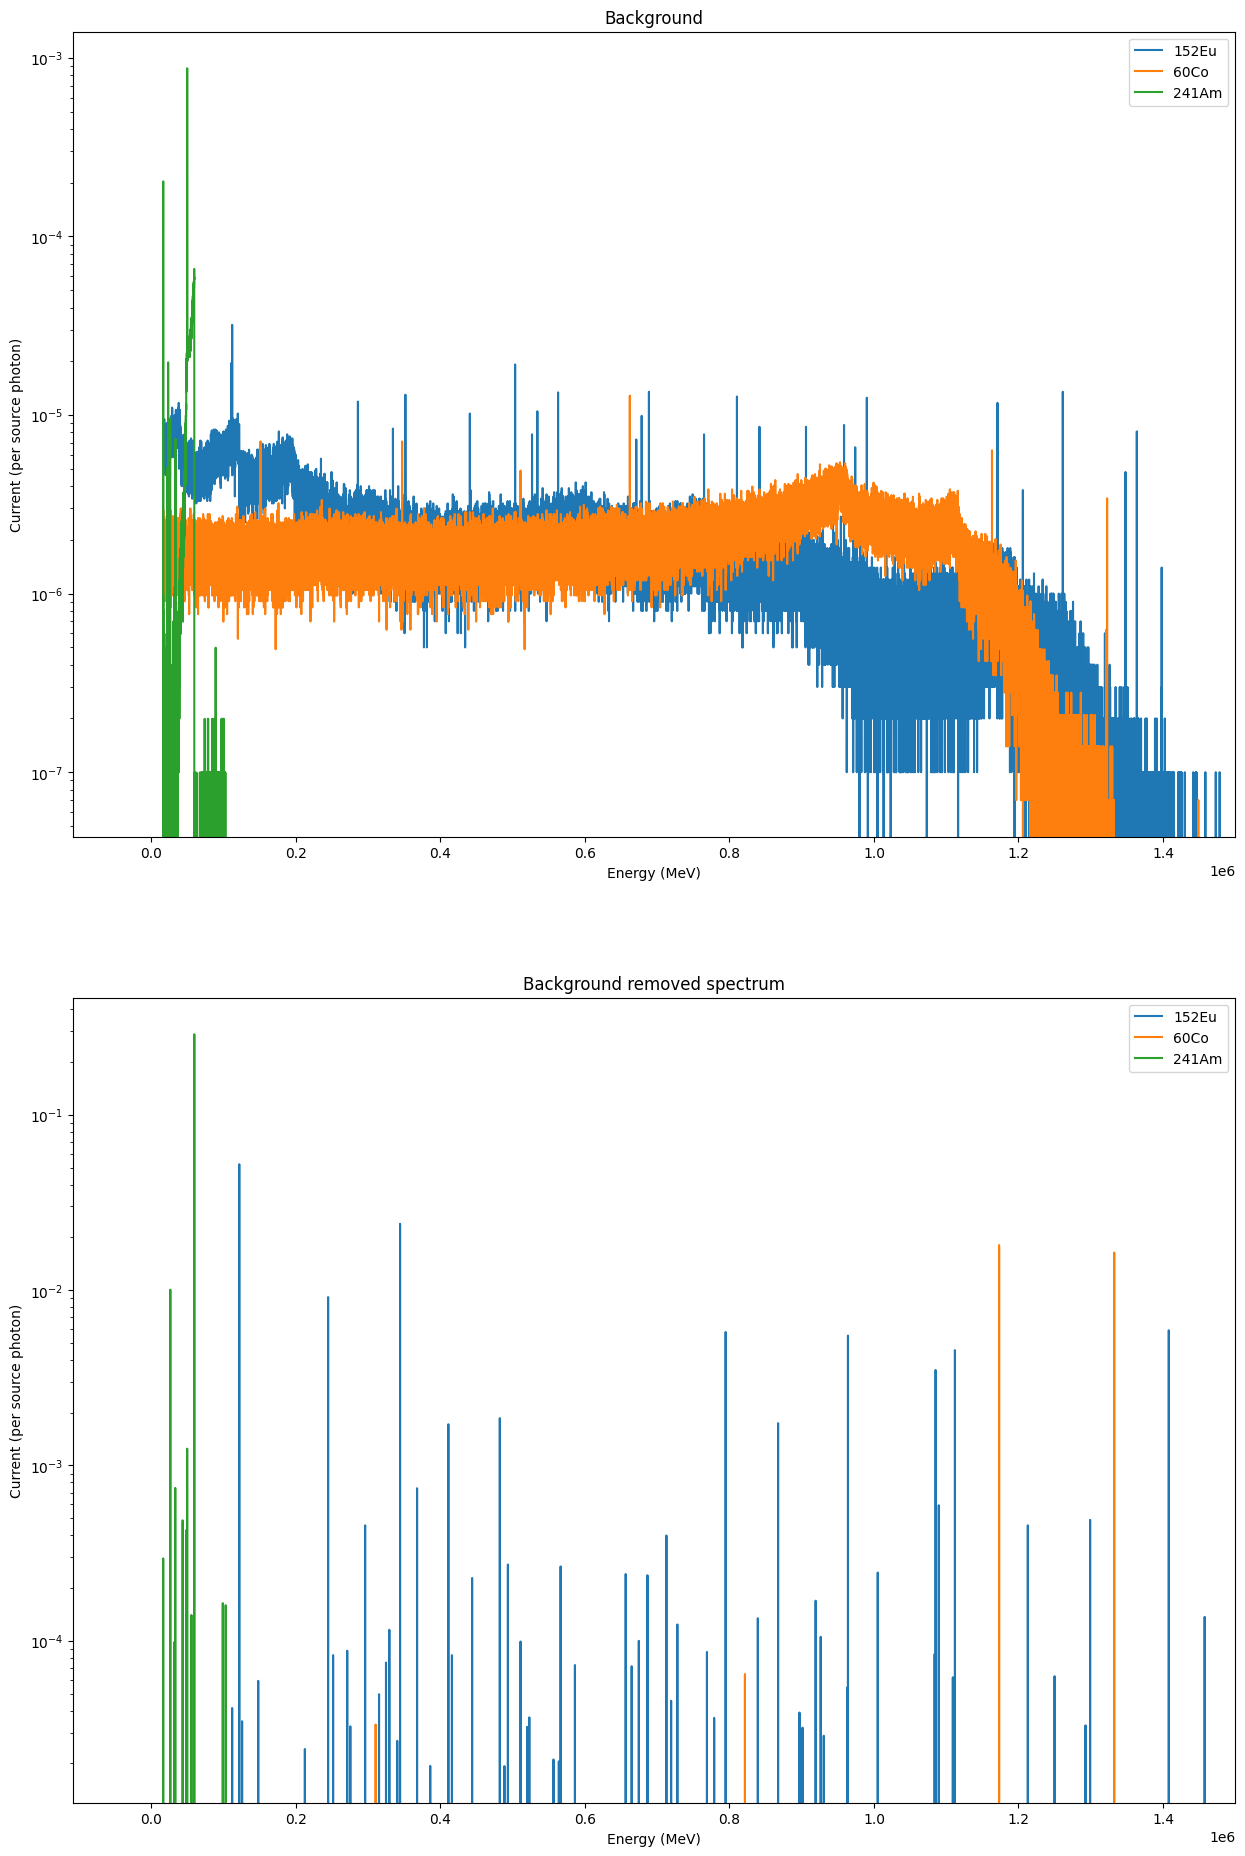

In [10]:
fig, ax = plt.subplots(2,1)
fig.set_figheight(23)
fig.set_figwidth(15)

europium_background = openmc_tools.find_background_spectrum(energy_bins[:-1], europium_spectrum)
cobalt_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_cobalt_spectrum)
americium_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_americium_spectrum)
backgrounds_array = [europium_background, cobalt_background, americium_background]

europium_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(europium_spectrum, europium_background)
cobalt_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_cobalt_spectrum, cobalt_background)
americium_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_americium_spectrum, americium_background)
background_removed_spectra_array = [europium_background_removed_spectrum, cobalt_background_removed_spectrum, americium_background_removed_spectrum]

for i in range(len(labels)):
    ax[0].plot(energy_bins[:-1], backgrounds_array[i], label = labels[i])
    ax[1].plot(energy_bins[:-1], background_removed_spectra_array[i], label = labels[i])

    
ax[0].set_yscale('log')
#ax[0].set_ylim((1e-6, 1))
ax[0].set_xlim(right = 1.5E6)
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Current (per source photon)')
ax[0].set_title('Background')
ax[0].legend()

ax[1].set_yscale('log')
#ax[1].set_ylim((1e-6, 1))
ax[1].set_xlim(right = 1.5E6)
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_ylabel('Current (per source photon)')
ax[1].set_title('Background removed spectrum')
ax[1].legend()

plt.show()

## Finding the peaks in the data

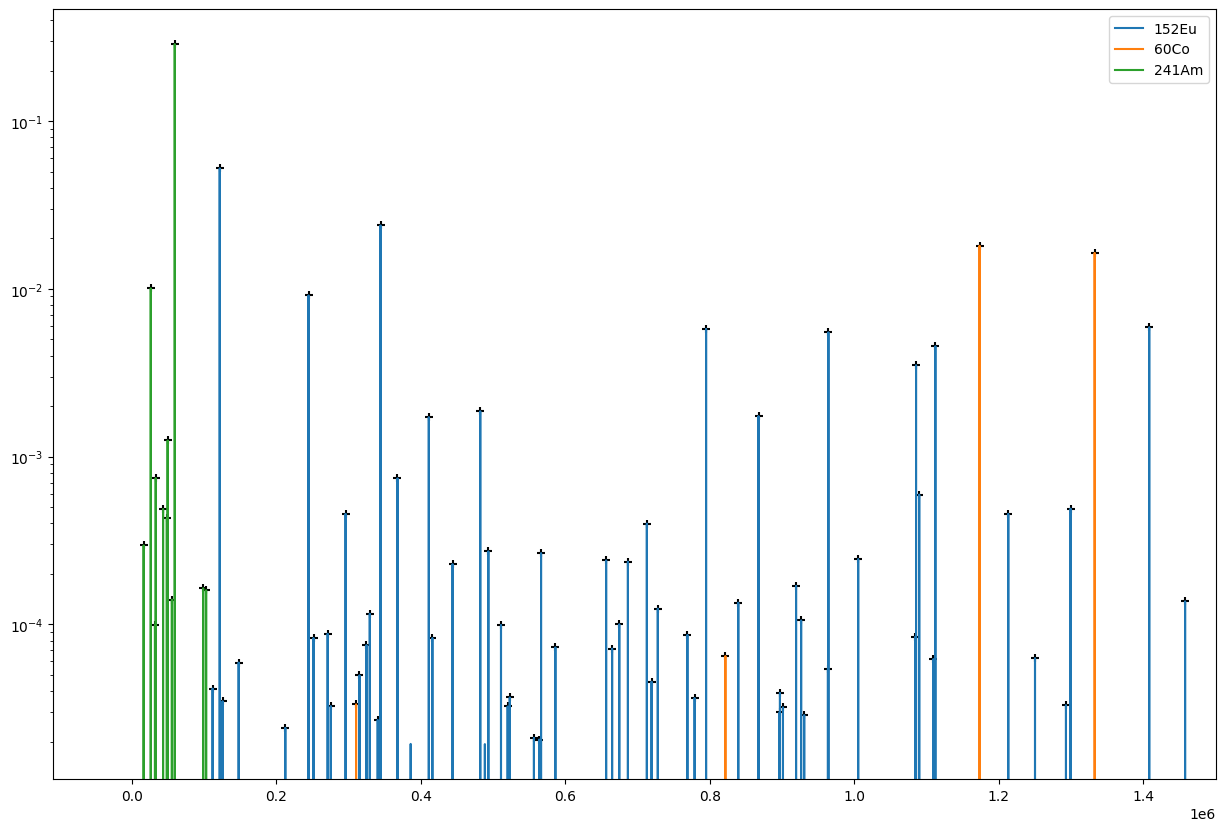

[310470.74329343287, 821492.422914229, 1173204.1061590617, 1332489.1088110881]
[3.331673496916623e-05, 6.464493183022426e-05, 0.018062345162173813, 0.016370831851477485]
0.003948787234314546
0.0020351277975015885


In [11]:
fig = plt.figure(figsize=[15, 10])

europium_peaks_location, europium_peaks = openmc_tools.find_peaks(energy_bins[:-1], europium_background_removed_spectrum)
cobalt_peaks_location, cobalt_peaks = openmc_tools.find_peaks(energy_bins[:-1], cobalt_background_removed_spectrum)
americium_peaks_location, americium_peaks = openmc_tools.find_peaks(energy_bins[:-1], americium_background_removed_spectrum)

peak_locations_array = [europium_peaks_location, cobalt_peaks_location, americium_peaks_location]
peaks_array = [europium_peaks, cobalt_peaks, americium_peaks]

for i in range(len(labels)):
    plt.plot(energy_bins[:-1], background_removed_spectra_array[i], label = labels[i])
    plt.scatter(peak_locations_array[i], peaks_array[i], marker = '+', color = 'k')

plt.yscale('log')
#plt.ylim((1e-6, 1))
plt.xlim(right = 1.5E6)
plt.legend()
plt.show()

print(peak_locations_array[1])
print(peaks_array[1])

#find the ratio of escape peak height to peak height for 1332 keV peak in 60Co
se_peak_ratio = peaks_array[1][1] / peaks_array[1][-1]
de_peak_ratio = peaks_array[1][0] / peaks_array[1][-1]
print(se_peak_ratio)
print(de_peak_ratio)

## Finding absolute efficiency

calculating absolute efficiency by finding the ratio of the peak heights to the number of photons emitted at the peak energy

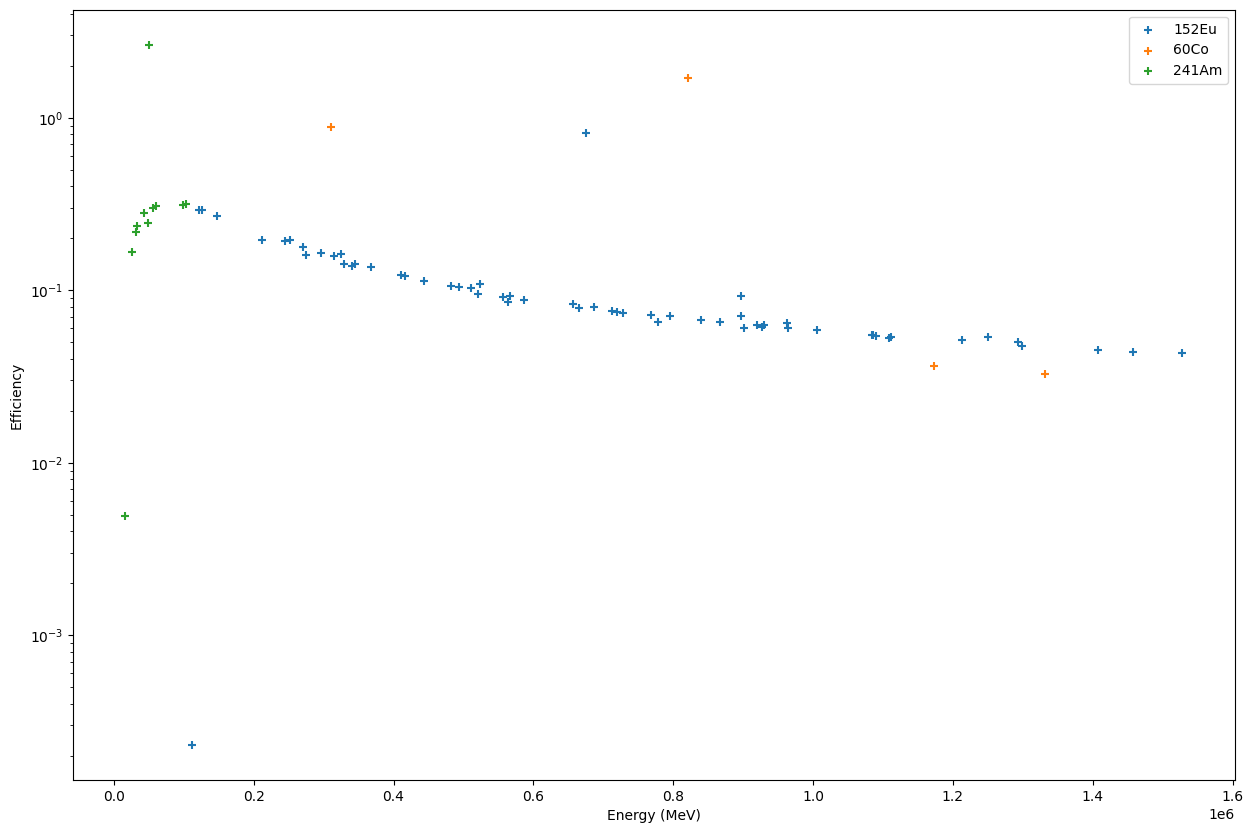

In [12]:
fig = plt.figure(figsize = [15,10])

europium_efficiency = openmc_tools.find_absolute_efficiency(europium_peaks_location, europium_peaks, europium_energy_peaks_ev,
                                                            europium_decay_probabilities)
cobalt_efficiency = openmc_tools.find_absolute_efficiency(cobalt_peaks_location, cobalt_peaks, cobalt_energy_peaks_ev, cobalt_decay_probabilities)
americium_efficiency = openmc_tools.find_absolute_efficiency(americium_peaks_location, americium_peaks, americium_energy_peaks_ev,
                                                            americium_decay_probabilities)

efficiencies_array = [europium_efficiency, cobalt_efficiency, americium_efficiency]

for i in range(len(labels)):
    plt.scatter(peak_locations_array[i], efficiencies_array[i], marker = '+', label = labels[i])

plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

## Applying Gaussian broadening

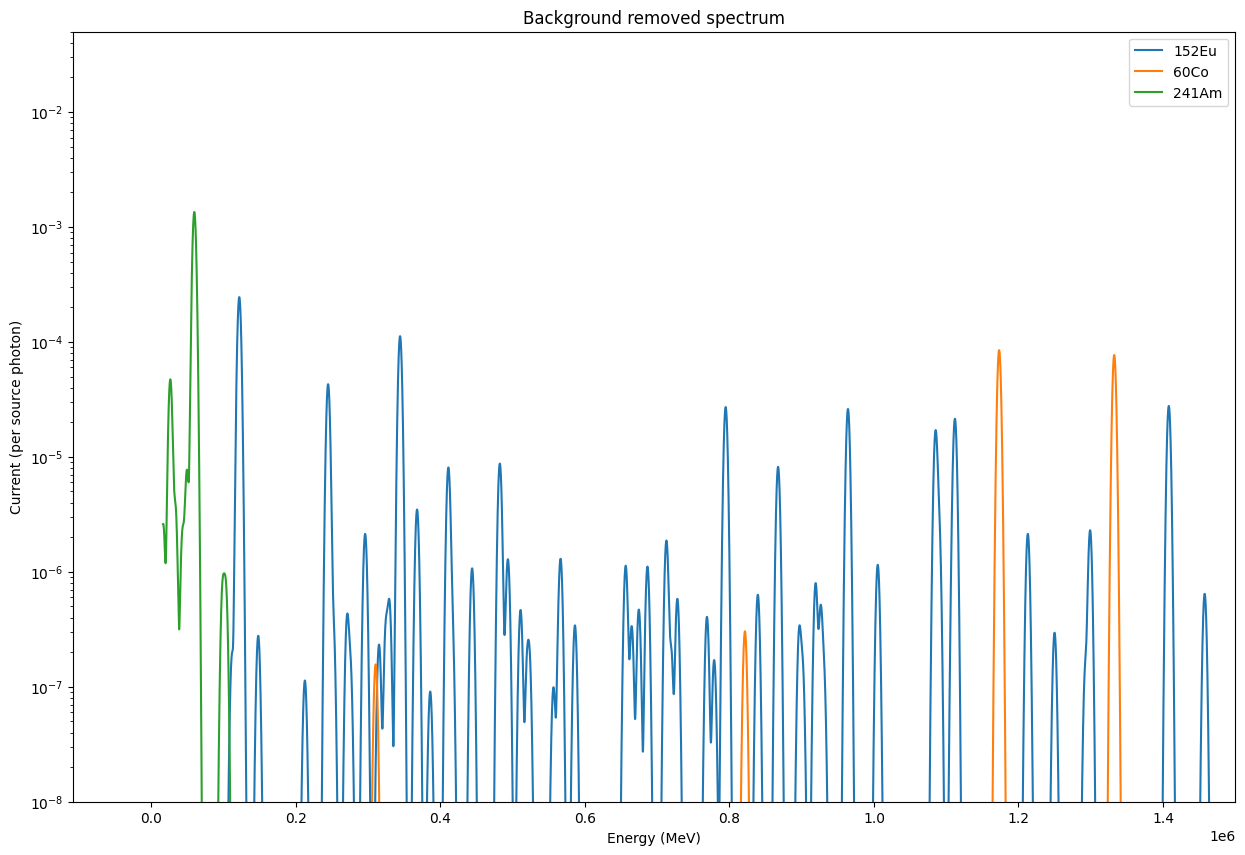

In [13]:
plt.figure(figsize = [15, 10])

europium_fwhm = 5000.0
cobalt_fwhm = 5000.0
americium_fwhm = 5000.0

broadened_europium_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], europium_background_removed_spectrum, europium_fwhm)
broadened_cobalt_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], cobalt_background_removed_spectrum, cobalt_fwhm)
broadened_americium_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], americium_background_removed_spectrum, americium_fwhm)

broadened_spectra_array = [broadened_europium_spectrum, broadened_cobalt_spectrum, broadened_americium_spectrum]

for i in range(len(labels)):
    plt.plot(energy_bins[:-1], broadened_spectra_array[i], label = labels[i])

plt.yscale('log')
plt.ylim((1e-8, 0.05))
plt.xlim(right = 1.5E6)
plt.xlabel('Energy (MeV)')
plt.ylabel('Current (per source photon)')
plt.title('Background removed spectrum')
plt.legend()
plt.show()